In [ ]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pycaret.regression import RegressionExperiment

from modules.ETL import ETL
from modules.feature_creation import FeatureCreation

plt.style.use("seaborn-v0_8")

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import get_scorer, get_scorer_names
from sklearn.model_selection import GridSearchCV

In [3]:
df_yield = pd.read_csv("data/barley_yield_from_1982.csv", sep=";")  # 1982 to 2018
df_climate = pd.read_parquet(
    "data/climate_data_from_1982.parquet"
)  # 1982-2014 2015-2050

In [4]:
df_yield, df_climate = ETL(df_yield, df_climate).run()

--- df_climate---
Departments/Scenario dropped because of any missing values:                                 department  scenario
date                                                
2015-01-01 12:00:00               Calvados  ssp2_4_5
2015-01-01 12:00:00            Deux_Sevres  ssp2_4_5
2015-01-01 12:00:00                Essonne  ssp2_4_5
2015-01-01 12:00:00                   Eure  ssp2_4_5
2015-01-01 12:00:00                  Rhone  ssp2_4_5
2015-01-01 12:00:00        Tarn_et_Garonne  ssp2_4_5
2015-01-01 12:00:00  Territoire_de_Belfort  ssp2_4_5
2015-01-01 12:00:00               Vaucluse  ssp2_4_5
--- df_yield ---
Departments dropped because of almost absolute absence of data:
 ['Hauts_de_Seine' 'Paris' 'Seine_SeineOise']


In [ ]:
df_hist, df_forecast = FeatureCreation(df_yield, df_climate).run()
if "cagr" in df_hist.columns:
    df_hist.drop(df_hist[df_hist["cagr"].isna()].index, inplace=True)

--- Amplitude feature created over phases ---
--- Threshold days feature created over phases ---
--- Temperature categories feature created ---
--- Consecutive days feature created ---
--- Annual precipitation category feature created ---
--- Calculating lagged features for yield ---
--- Yield lagged features calculated ---
--- Estimating future yields using historical CAGR ---
--- Future yields CAGR ---


In [113]:
df_hist

,year,department,yield,area,production,scenario,code_dep,daily_NSA_temp_amplitude_Q1,daily_NSA_temp_amplitude_Q2,daily_NSA_temp_amplitude_Q3,...,max_consecutive_above_germination,max_consecutive_above_growth,max_consecutive_above_maturation,max_consecutive_below_germination,max_consecutive_below_growth,max_consecutive_below_maturation,annual_precip_below,annual_precip_within,annual_precip_above,cagr
0,1982,Ain,3.950080,16065.0,63458.0,historical,01,19.501831,19.293884,15.172821,...,0.0,0.0,0.0,61.0,25.0,6.0,0,0,1,NaN
1,1983,Ain,2.648276,14500.0,38400.0,historical,01,18.292297,18.553345,16.015930,...,0.0,0.0,0.0,61.0,46.0,12.0,0,0,1,-0.329564
2,1984,Ain,4.822580,15500.0,74750.0,historical,01,21.210449,19.159363,15.992889,...,0.0,0.0,0.0,61.0,31.0,9.0,0,0,1,0.821026
3,1985,Ain,4.196770,15500.0,65050.0,historical,01,17.951660,21.640381,8.846832,...,0.0,0.0,0.0,61.0,32.0,11.0,0,0,1,-0.129767
4,1986,Ain,3.598450,12900.0,46420.0,historical,01,15.292114,21.908600,12.199310,...,0.0,0.0,0.0,61.0,19.0,10.0,0,0,1,-0.142567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,2010,Yvelines,7.037840,9624.0,67732.2,historical,78,12.858643,22.911469,12.179871,...,0.0,0.0,9.0,61.0,9.0,2.0,0,0,1,-0.079642
2933,2011,Yvelines,6.155870,8766.0,53962.4,historical,78,15.492645,17.581879,14.265411,...,0.0,0.0,2.0,61.0,21.0,2.0,0,0,1,-0.125318
2934,2012,Yvelines,7.675490,9100.0,69847.0,historical,78,16.795593,20.079193,19.806976,...,0.0,0.0,5.0,61.0,16.0,6.0,0,0,1,0.246857
2935,2013,Yvelines,7.043820,10360.0,72974.0,historical,78,15.895905,20.940186,15.685059,...,0.0,0.0,2.0,61.0,14.0,1.0,0,0,1,-0.082297


In [8]:
df_forecast

,year,scenario,department,code_dep,daily_NSA_temp_amplitude_Q1,daily_NSA_temp_amplitude_Q2,daily_NSA_temp_amplitude_Q3,daily_NSA_temp_amplitude_Q4,daily_NSA_temp_mean_Q1,daily_NSA_temp_mean_Q2,...,growth_within,maturation_above,maturation_below,maturation_within,max_consecutive_above_germination,max_consecutive_above_growth,max_consecutive_above_maturation,max_consecutive_below_germination,max_consecutive_below_growth,max_consecutive_below_maturation
0,2015,ssp1_2_6,Ain,01,11.738373,22.835358,22.317291,20.416016,276.865204,286.207550,...,85.0,2.0,7.0,52.0,0.0,0.0,2.0,61.0,26.0,6.0
1,2016,ssp1_2_6,Ain,01,14.805573,16.056213,13.140747,19.678406,279.027893,285.609863,...,116.0,0.0,7.0,54.0,0.0,0.0,0.0,61.0,24.0,7.0
2,2017,ssp1_2_6,Ain,01,17.372681,20.297424,11.332092,18.838562,275.093353,286.320190,...,96.0,0.0,6.0,55.0,0.0,0.0,0.0,61.0,33.0,4.0
3,2018,ssp1_2_6,Ain,01,18.234802,15.198212,11.735962,25.785767,277.419281,285.208649,...,100.0,0.0,21.0,40.0,0.0,0.0,0.0,53.0,28.0,7.0
4,2019,ssp1_2_6,Ain,01,12.973999,21.493591,16.736206,14.886719,276.362579,285.093018,...,90.0,1.0,24.0,36.0,0.0,0.0,1.0,61.0,14.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9319,2046,ssp5_8_5,Yvelines,78,14.077454,24.115509,15.519806,18.629150,279.256866,287.483246,...,132.0,22.0,3.0,36.0,0.0,3.0,8.0,61.0,16.0,2.0
9320,2047,ssp5_8_5,Yvelines,78,16.145782,20.733887,17.373383,22.464966,278.578094,287.481323,...,123.0,22.0,3.0,36.0,0.0,0.0,10.0,56.0,14.0,2.0
9321,2048,ssp5_8_5,Yvelines,78,15.410065,17.898407,21.749695,18.188293,277.136200,288.146027,...,111.0,10.0,6.0,45.0,0.0,3.0,5.0,61.0,23.0,4.0
9322,2049,ssp5_8_5,Yvelines,78,13.058807,19.879333,18.834961,20.051270,279.944061,288.088013,...,146.0,11.0,2.0,48.0,0.0,0.0,6.0,61.0,9.0,2.0


# Prepare data


In [126]:
df_hist_2014 = df_hist[df_hist["year"] <= 2014]

In [115]:
df_forecast_126 = df_forecast[df_forecast["scenario"] == "ssp1_2_6"]
df_forecast_245 = df_forecast[df_forecast["scenario"] == "ssp2_4_5"]
df_forecast_585 = df_forecast[df_forecast["scenario"] == "ssp5_8_5"]

In [127]:
# Filter data after 2030
df_forecast_126 = df_forecast_126[df_forecast_126["year"] <= 2030].reset_index(
    drop=True
)
df_forecast_245 = df_forecast_245[df_forecast_245["year"] <= 2030].reset_index(
    drop=True
)
df_forecast_585 = df_forecast_585[df_forecast_585["year"] <= 2030].reset_index(
    drop=True
)

In [128]:
df_hist_train = df_hist_2014
target = "yield"
dep_cols = list(df_hist_train.columns[df_hist_train.columns.str.contains("dep")])
print("Dropped Department columns : ", dep_cols)
df_hist_train = df_hist_train.drop(columns=["production", "scenario"] + dep_cols)

Dropped Department columns :  ['department', 'code_dep']


In [129]:
df_hist_train.head()

,year,yield,area,daily_NSA_temp_amplitude_Q1,daily_NSA_temp_amplitude_Q2,daily_NSA_temp_amplitude_Q3,daily_NSA_temp_amplitude_Q4,daily_NSA_temp_mean_Q1,daily_NSA_temp_mean_Q2,daily_NSA_temp_mean_Q3,...,max_consecutive_above_germination,max_consecutive_above_growth,max_consecutive_above_maturation,max_consecutive_below_germination,max_consecutive_below_growth,max_consecutive_below_maturation,annual_precip_below,annual_precip_within,annual_precip_above,cagr
1,1983,2.648276,14500.0,18.292297,18.553345,16.015930,26.968567,275.036713,285.042694,289.147247,...,0.0,0.0,0.0,61.0,46.0,12.0,0,0,1,-0.329564
2,1984,4.822580,15500.0,21.210449,19.159363,15.992889,21.758179,275.993958,284.692688,289.896545,...,0.0,0.0,0.0,61.0,31.0,9.0,0,0,1,0.821026
3,1985,4.196770,15500.0,17.951660,21.640381,8.846832,23.074890,274.739990,284.293854,290.097107,...,0.0,0.0,0.0,61.0,32.0,11.0,0,0,1,-0.129767
4,1986,3.598450,12900.0,15.292114,21.908600,12.199310,20.551178,277.031097,284.711151,289.784210,...,0.0,0.0,0.0,61.0,19.0,10.0,0,0,1,-0.142567
5,1987,4.920000,15000.0,19.442352,19.173187,14.216736,27.078552,274.327667,283.722321,289.883881,...,0.0,0.0,0.0,61.0,46.0,6.0,0,0,1,0.367255


# Baseline model comparison


We will use pycaret to quickly compare the performance of different models on the dataset before actually selecting the best model for further tuning.


In [ ]:
s = RegressionExperiment()
s.setup(df_hist_train, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,yield
2,Target type,Regression
3,Original data shape,"(2934, 70)"
4,Transformed data shape,"(2934, 70)"
5,Transformed train set shape,"(2053, 70)"
6,Transformed test set shape,"(881, 70)"
7,Numeric features,68
8,Categorical features,1
9,Preprocess,True


In [28]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4904,0.3944,0.6274,0.7885,0.1163,0.1110,0.3270
et,Extra Trees Regressor,0.5101,0.4175,0.6452,0.7766,0.1203,0.1169,0.2620
xgboost,Extreme Gradient Boosting,0.5323,0.4656,0.6815,0.7510,0.1267,0.1213,0.1640
rf,Random Forest Regressor,0.5629,0.5065,0.7103,0.7292,0.1303,0.1277,0.7130
gbr,Gradient Boosting Regressor,0.5686,0.5160,0.7171,0.7243,0.1311,0.1285,0.5160
ada,AdaBoost Regressor,0.6923,0.7304,0.8534,0.6104,0.1523,0.1549,0.1720
lr,Linear Regression,0.6890,0.7496,0.8638,0.6009,0.1566,0.1550,0.3300
ridge,Ridge Regression,0.7055,0.7884,0.8857,0.5812,0.1591,0.1587,0.0150
br,Bayesian Ridge,0.7071,0.7898,0.8865,0.5805,0.1592,0.1592,0.0150
en,Elastic Net,0.8333,1.0749,1.0356,0.4276,0.1855,0.1916,0.0130


In [38]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Feature Selection Boruta


In [ ]:
from BorutaShap import BorutaShap

feat_selector = BorutaShap(importance_measure="shap", classification=False)
feat_selector.fit(
    X=df_hist_train.drop(columns=[target]),
    y=df_hist_train[target],
    n_trials=20,
    random_state=123,
)

  0%|          | 0/20 [00:00<?, ?it/s]

26 attributes confirmed important: ['rainy_days_maturation', 'frost_days_germination', 'maturation_below', 'max_consecutive_within_growth', 'rainy_days_growth', 'amp_max_daily_NSA_temp_Q4', 'amp_daily_NSA_temp_Q2', 'max_consecutive_within_maturation', 'year', 'growth_below', 'max_consecutive_below_growth', 'area', 'amp_daily_NSA_temp_Q1', 'amp_precipitation_Q1', 'rainy_days_germination', 'amp_precipitation_Q2', 'amp_max_daily_NSA_temp_Q3', 'max_consecutive_below_maturation', 'heat_days_maturation', 'amp_max_daily_NSA_temp_Q2', 'amp_precipitation_Q4', 'amp_daily_NSA_temp_Q3', 'amp_max_daily_NSA_temp_Q1', 'maturation_within', 'amp_precipitation_Q3', 'amp_daily_NSA_temp_Q4']
17 attributes confirmed unimportant: ['heat_days_germination', 'annual_precip_within', 'max_consecutive_above_growth', 'max_consecutive_above_germination', 'frost_days_maturation', 'annual_precip_below', 'max_consecutive_within_germination', 'max_consecutive_above_maturation', 'growth_above', 'germination_below', 'ger

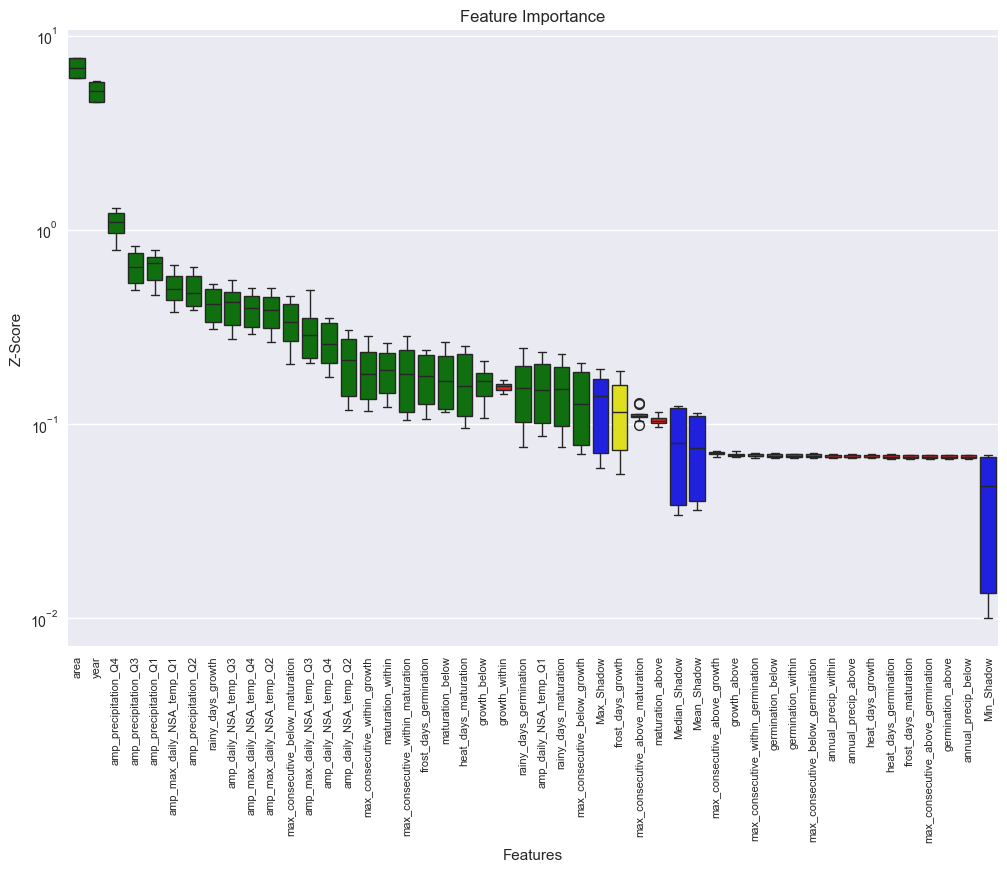

In [9]:
feat_selector.plot(which_features="all")

In [11]:
feat_selector.results_to_csv("boruta_shap_results.csv")

In [ ]:
selected_feat_boruta = feat_selector.accepted
rejected_feat_boruta = feat_selector.rejected
tentative_feat_boruta = feat_selector.tentative

# Feature Selection with XGBoost


In [119]:
# We will add a random feature to the features and train XGBoost model. We will drop all the features with an importance score lower than the random feature.

X = df_hist_train.drop(columns=[target])
y = df_hist_train[target]
n = 50
removed_features = set()
for i in range(n):
    # Add a random feature
    X["random_feature"] = np.random.rand(X.shape[0])

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = XGBRegressor()
    model.fit(X_scaled, y)

    importance = model.feature_importances_

    importance_df = pd.DataFrame(
        {"feature": X.columns, "importance": importance}
    ).sort_values("importance", ascending=False)

    to_remove = importance_df[importance_df["importance"] < importance[-1]]["feature"]
    removed_features.update(to_remove)

removed_features = list(removed_features)

# Select K Best


In [130]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_hist_train.drop(columns=[target])
y = df_hist_train[target]

# Perform selectKBest with f_regression
selector = SelectKBest(score_func=f_regression, k=20)
selector.fit(X, y)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
selected_features = X.columns[cols]
rejected_Kbest = [col for col in X.columns if col not in selected_features]

# Final Feature Selection


In [131]:
rejected_feat_boruta = pd.read_csv("boruta_shap_results.csv")
rejected_feat_boruta = rejected_feat_boruta[
    rejected_feat_boruta["Decision"] == "Rejected"
]["Features"]
rejected_feat_boruta = list(rejected_feat_boruta)

In [160]:
final_rejected = list(
    set(rejected_feat_boruta) | set(removed_features) | set(rejected_Kbest)
)
final_rejected = [col for col in final_rejected if col in df_hist_train.columns]
final_rejected = removed_features
final_rejected

['germination_below',
 'maturation_within',
 'daily_NSA_temp_amplitude_Q2',
 'annual_precip_below',
 'heat_days_germination',
 'rainy_days_germination',
 'annual_precip_above',
 'daily_NSA_temp_std_Q1',
 'annual_precip_within',
 'max_consecutive_above_growth',
 'daily_NSA_temp_std_Q3',
 'germination_within',
 'max_consecutive_above_germination',
 'max_consecutive_below_germination',
 'daily_NSA_temp_mean_Q1',
 'heat_days_growth',
 'growth_above',
 'max_consecutive_above_maturation',
 'daily_NSA_temp_amplitude_Q4',
 'growth_within',
 'frost_days_maturation',
 'germination_above',
 'maturation_below']

# Train Test Split


In [161]:
target = "yield"
X = df_hist_train.drop(columns=[target] + final_rejected)
y = df_hist_train[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Grid Search


In [134]:
from skopt import BayesSearchCV
from skopt.plots import plot_objective

In [158]:
score_names = [
    "r2",
    "neg_mean_absolute_error",
    "neg_root_mean_squared_error",
    "neg_mean_absolute_percentage_error",
]

models = {
    # "CatBoostRegressor": CatBoostRegressor(verbose=0),
    "LGBMRegressor": LGBMRegressor(verbose=-1),
    "XGBRegressor": XGBRegressor(),
}

In [162]:
from search_grids import bayes_search_params, grid_search_params

best_model = None
best_score = -np.inf
best_search = None
for model_name, model in models.items():
    print("----------", model_name, "----------")
    pipe = Pipeline([("scaler", StandardScaler()), (model_name, model)])
    scorer = get_scorer("neg_mean_absolute_error")
    search = GridSearchCV(pipe, grid_search_params[model_name], scoring=scorer, cv=3)
    search.fit(X_train, y_train)
    model_selected = search.best_estimator_
    print("-- TRAIN")
    for score_name in score_names:
        scorer = get_scorer(score_name)
        score = scorer(model_selected, X_train, y_train)
        print(score_name, " : ", score)
    print("-- TEST")
    for score_name in score_names:
        scorer = get_scorer(score_name)
        score = scorer(model_selected, X_test, y_test)
        print(score_name, " : ", score)

    if score > best_score:
        best_score = score
        best_model = model_selected
        best_search = search

print("Params : ", best_search.best_params_)

---------- LGBMRegressor ----------
-- TRAIN
r2  :  0.9251045195060876
neg_mean_absolute_error  :  -0.28519699689793987
neg_root_mean_squared_error  :  -0.3623448575136747
neg_mean_absolute_percentage_error  :  -0.06202521984602521
-- TEST
r2  :  0.8179120866186508
neg_mean_absolute_error  :  -0.47209726724191875
neg_root_mean_squared_error  :  -0.5943210814458157
neg_mean_absolute_percentage_error  :  -0.10762678562371954
---------- XGBRegressor ----------
-- TRAIN
r2  :  0.934450576516856
neg_mean_absolute_error  :  -0.2653679091576336
neg_root_mean_squared_error  :  -0.338983636695122
neg_mean_absolute_percentage_error  :  -0.05754443395157004
-- TEST
r2  :  0.807207324393647
neg_mean_absolute_error  :  -0.4831338066550281
neg_root_mean_squared_error  :  -0.6115413692381075
neg_mean_absolute_percentage_error  :  -0.1098217599342047
Params :  {'LGBMRegressor__reg_alpha': 10.0, 'LGBMRegressor__reg_lambda': 10.0}


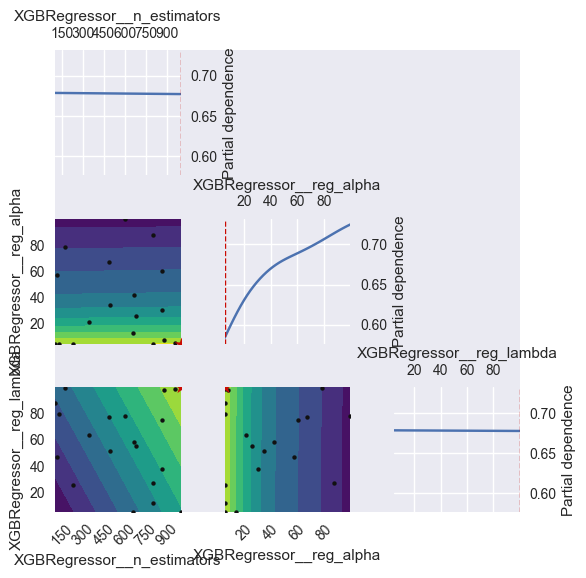

In [78]:
_ = plot_objective(search.optimizer_results_[0])

# Evaluation


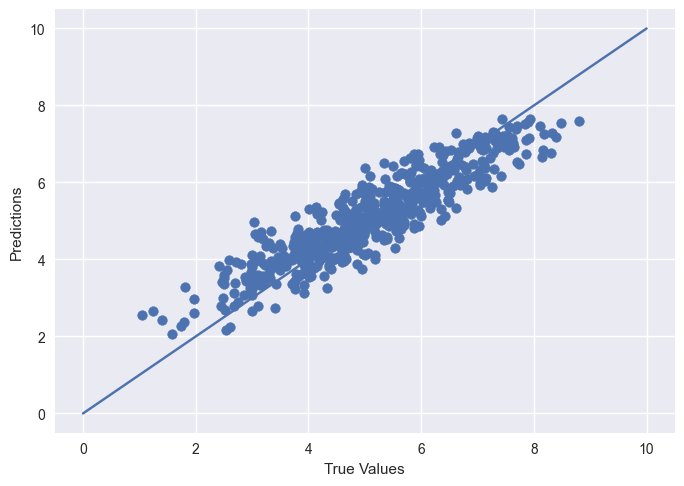

In [163]:
# Plot y_test vs y_pred
y_pred = best_model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

_ = plt.plot([0, 10], [0, 10])

plt.show()

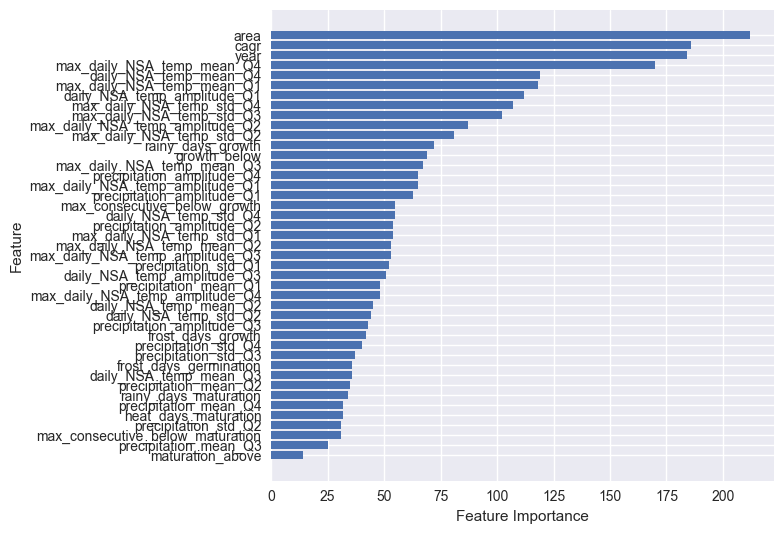

In [164]:
# Plot feature importances of the best model

feature_importances = best_model[-1].feature_importances_
feature_names = X_train.columns
sorted_idx = feature_importances.argsort()

plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Prediction formatting


In [165]:
def predict_format(df_area, df_predict, model, col_to_drop, target):
    departments = df_predict["department"]
    scenario = df_predict["scenario"]
    code_dep = df_predict["code_dep"]
    # If the df_predict is not historical, it needs to get the last historical data
    if df_area["year"].max() <= df_predict["year"].min():
        # Assing to each row of df_predict the "area" of the last historical year from df_hist where department are matching
        df_predict = df_predict.merge(
            df_area[df_area["year"] == df_area["year"].max()][
                ["area", "department", "code_dep"]
            ],
            on=["department", "code_dep"],
            how="left",
        )
    else:
        df_predict = df_predict.drop(columns=target)
    df_predict = df_predict.drop(
        columns=col_to_drop + ["department", "code_dep", "scenario"]
    )
    # Re arrange the order of the columns to put area as second column (to reproduce the same order as the training set)
    cols = df_predict.columns.tolist()
    cols = cols[:1] + cols[-1:] + cols[1:-1]
    df_predict = df_predict[cols]
    y_pred = model.predict(df_predict)
    df_predict["yield_pred"] = y_pred
    df_predict["department"] = departments
    df_predict["scenario"] = scenario
    df_predict["code_dep"] = code_dep
    return df_predict

In [167]:
df_pred_126 = predict_format(
    df_hist_2014, df_forecast_126, best_model, final_rejected, target
)
df_pred_245 = predict_format(
    df_hist_2014, df_forecast_245, best_model, final_rejected, target
)
df_pred_585 = predict_format(
    df_hist_2014, df_forecast_585, best_model, final_rejected, target
)

dfs_pred = {"ssp126": df_pred_126, "ssp245": df_pred_245, "ssp585": df_pred_585}

# Evaluate the prediction (2015-2018) on the climate forecast


In [168]:
df_hist_2018 = df_yield[df_yield.index.year > 2014].reset_index()
df_hist_2018["year"] = df_hist_2018["year"].apply(lambda x: x.year)
df_hist_2018

,year,department,yield,area,production
0,2015,Ain,6.90,8165.0,56717.50
1,2016,Ain,5.47,9530.0,52129.10
2,2017,Ain,6.57,9300.0,61101.00
3,2018,Ain,6.19,8870.0,54905.30
4,2015,Aisne,8.40,46850.0,391473.00
...,...,...,...,...,...
371,2018,Yonne,6.10,78610.0,479521.00
372,2015,Yvelines,8.00,11420.0,91400.50
373,2016,Yvelines,5.30,12225.0,64792.50
374,2017,Yvelines,7.31,13735.0,100402.85


In [170]:
error_pct_dict = {}
for dep in df_pred_126["department"].unique():
    # Filter to keep only prediction between 2015 and 2018
    df_pred_126_dep = df_pred_126[
        (df_pred_126["department"] == dep) & (df_pred_126["year"] <= 2018)
    ]
    # Calculate the percentage precision of the prediction between df_hist_2018 and df_pred_126_dep
    df_hist_2018_dep = df_hist_2018[df_hist_2018["department"] == dep]
    df_hist_2018_dep = df_hist_2018_dep.merge(
        df_pred_126_dep[["year", "yield_pred"]], on="year", how="left"
    )
    pct_error = (
        (df_hist_2018_dep["yield"] - df_hist_2018_dep["yield_pred"])
        / df_hist_2018_dep["yield"]
    ) * 100
    df_hist_2018_dep["pct_error"] = pct_error
    error_pct_dict[dep] = df_hist_2018_dep[["pct_error", "year"]]

# Yield Moyen France


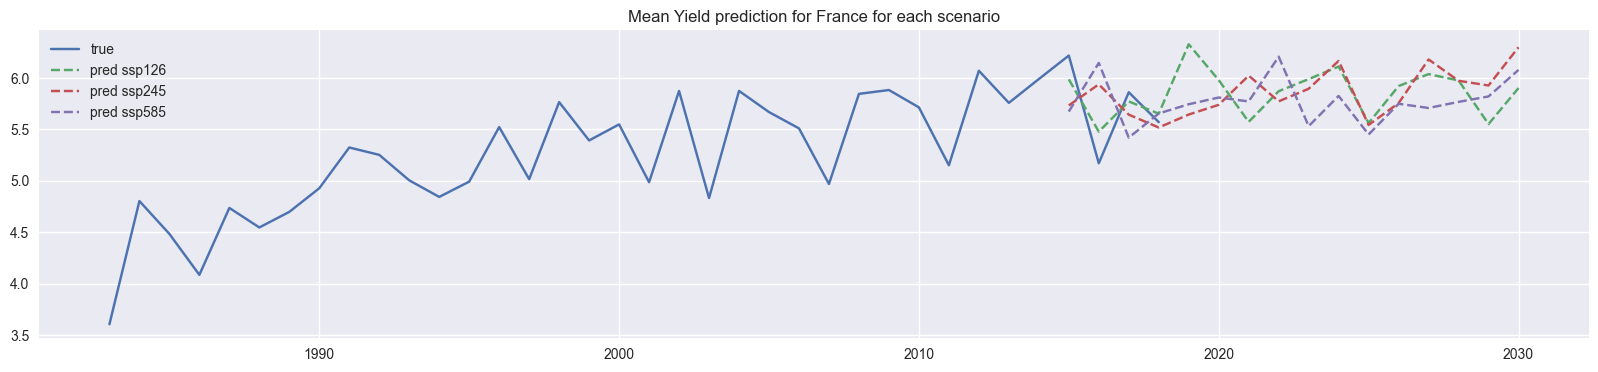

In [171]:
plt.figure(figsize=(20, 4))

df_france = df_hist_2014.groupby("year").mean(numeric_only=True)["yield"]
df_france = pd.concat(
    [df_france, df_hist_2018.groupby("year").mean(numeric_only=True)["yield"]]
)
plt.plot(df_france.index, df_france, label="true")

for scenario, df_scenario in dfs_pred.items():
    df_france = df_scenario.groupby("year").mean(numeric_only=True)["yield_pred"]
    plt.plot(df_france.index, df_france, label="pred " + scenario, linestyle="--")

plt.title("Mean Yield prediction for France for each scenario")
plt.legend()
plt.show()

# Top departements France


In [172]:
# We want to get for each year the top 10 department with the highest yield
# Let's do a sankey plot to see the evolution of the top 5 department over the years
n_top = 10
top_per_year = {}
dep_rank = {}
for year in df_pred_126["year"].unique():
    df_year = df_pred_126[df_pred_126["year"] == year]
    top_per_year[year] = df_year.nlargest(n_top, "yield_pred")["department"].tolist()
    df_year["rank"] = df_year["yield_pred"].rank(ascending=False)
    for dep in df_year["department"].unique():
        if dep not in dep_rank:
            dep_rank[dep] = []
        dep_rank[dep].append(df_year[df_year["department"] == dep]["rank"].values[0])

## Get the top 10 departements with the highest yield


In [173]:
dep_rank = pd.DataFrame(dep_rank)
dep_rank.index = df_pred_126["year"].unique()
dep_rank.mean().sort_values(ascending=True).head(10)

Somme              3.3750
Pas_de_Calais      3.7500
Seine_Maritime     6.4375
Aisne              6.5000
Seine_et_Marne     7.3125
Ardennes           8.6875
Eure               8.6875
Calvados          11.3750
Aube              12.3125
Finistere         12.5625
dtype: float64

## Plot difference between the top 10 departements and the average yield


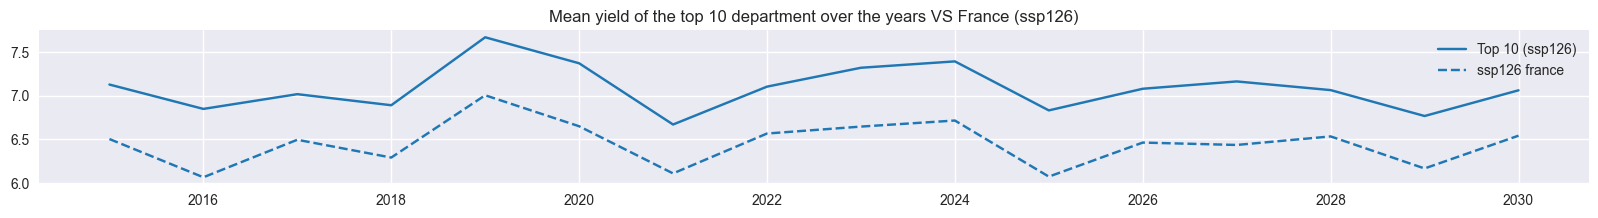

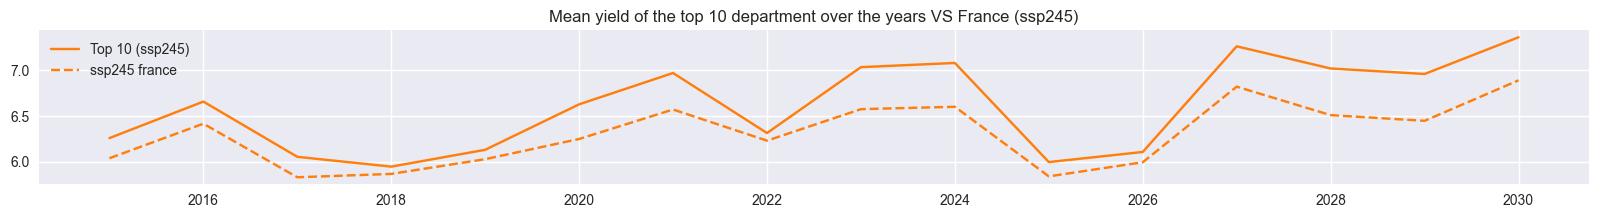

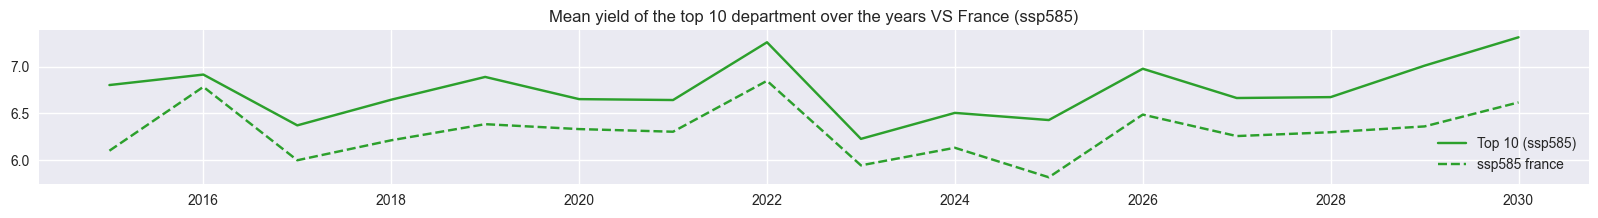

In [174]:
mean_france_list = {"ssp126": [], "ssp245": [], "ssp585": []}
mean_top_list = {"ssp126": [], "ssp245": [], "ssp585": []}
for year in top_per_year.keys():
    for scenario, df_scenario in dfs_pred.items():
        df_year = df_scenario[df_scenario["year"] == year]
        df_year["weighted_yield"] = (
            df_year["yield_pred"] * df_year["area"] / df_year["area"].sum()
        )
        mean_france = df_year["weighted_yield"].sum()
        df_top_5 = df_year[df_year["department"].isin(top_per_year[year])]
        mean_top = (
            df_top_5["yield_pred"] * df_top_5["area"] / df_top_5["area"].sum()
        ).sum()
        mean_top_list[scenario].append(mean_top)
        mean_france_list[scenario].append(mean_france)


colors = list(plt.cm.tab10.colors)
for scenario, mean_top in mean_top_list.items():
    fig, ax = plt.subplots(figsize=(20, 2))
    color = colors.pop(0)
    plt.plot(
        list(top_per_year.keys()),
        mean_top,
        label=f"Top {n_top} ({scenario})",
        color=color,
    )
    plt.plot(
        list(top_per_year.keys()),
        mean_france_list[scenario],
        label=scenario + " france",
        linestyle="--",
        color=color,
    )
    plt.title(
        f"Mean yield of the top {n_top} department over the years VS France ({scenario})"
    )
    plt.legend()
    plt.show()

In [411]:
import plotly.express as px
import seaborn as sns

year_list = sorted(list(df_pred_126["year"].unique()))
df_pred_126["posi"] = [year_list.index(year) for year in df_pred_126["year"]]

df_pred_126["rank"] = df_pred_126.groupby("year")["yield_pred"].rank(ascending=False)

list_dist = list(set(df_pred_126["department"]))
pal = list(sns.color_palette(palette="Spectral", n_colors=len(list_dist)).as_hex())
dict_color = dict(zip(list_dist, pal))

fig = px.scatter(
    df_pred_126,
    x="posi",
    y="rank",
    size="yield_pred",
    color="department",
    text="department",
    color_discrete_map=dict_color,
    animation_frame="year",
    animation_group="department",
    range_x=[-2, len(year_list)],
    range_y=[0.5, 6.5],
)

fig.update_xaxes(title="", visible=False)
fig.update_yaxes(autorange="reversed", title="Rank", visible=True, showticklabels=True)
fig.update_layout(
    xaxis=dict(showgrid=False), yaxis=dict(showgrid=True), width=2000, height=2000
)
fig.update_traces(textposition="middle left")
fig.show()

# Shap Values (Impact of each feature on the prediction)


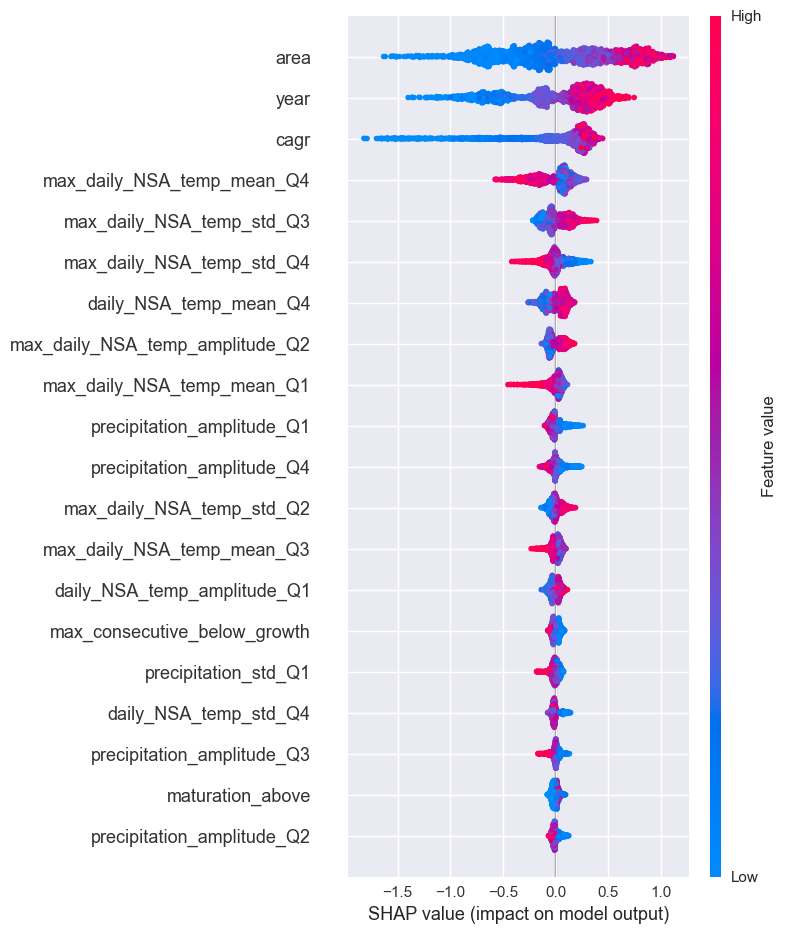

In [175]:
import shap

regressor = best_model[-1]
scaler = best_model[0]
explainer = shap.Explainer(regressor)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
shap_values = explainer(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled)

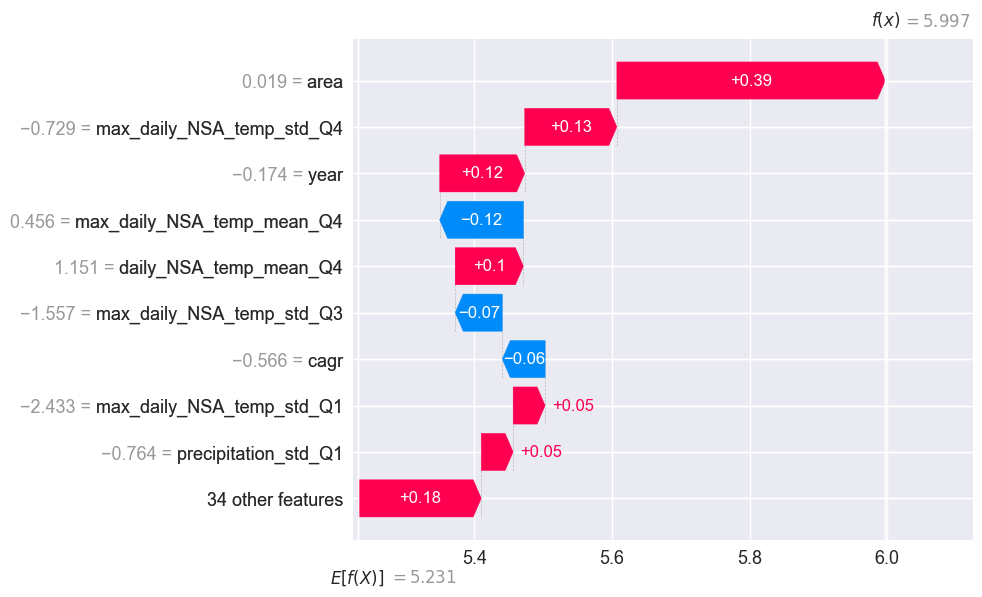

In [176]:
shap.waterfall_plot(shap_values[0])

# Visualisation on the Map


In [ ]:
import geopandas as gpd

url_shapefile = (
    "https://github.com/gregoiredavid/france-geojson/raw/master/departements.geojson"
)
map_df = gpd.read_file(url_shapefile)  # Read the GeoJSON file into a GeoDataFrame

In [561]:
df_pred_126

,year,area,daily_NSA_temp_amplitude_Q3,daily_NSA_temp_amplitude_Q4,daily_NSA_temp_mean_Q2,daily_NSA_temp_mean_Q3,daily_NSA_temp_mean_Q4,daily_NSA_temp_std_Q1,daily_NSA_temp_std_Q2,daily_NSA_temp_std_Q3,...,rainy_days_growth,rainy_days_maturation,growth_below,maturation_above,maturation_within,max_consecutive_below_growth,max_consecutive_below_maturation,yield_pred,department,scenario
0,2015,7350.0,22.317291,20.416016,286.207550,291.882629,278.086029,2.818761,4.925275,4.312538,...,50.0,9.0,97.0,2.0,52.0,26.0,6.0,5.145915,Ain,ssp1_2_6
1,2016,7350.0,13.140747,19.678406,285.609863,290.751282,279.529480,3.097974,4.207793,2.920630,...,59.0,16.0,67.0,0.0,54.0,24.0,7.0,5.567270,Ain,ssp1_2_6
2,2017,7350.0,11.332092,18.838562,286.320190,292.349609,278.192383,4.506082,5.448828,2.629587,...,58.0,11.0,86.0,0.0,55.0,33.0,4.0,5.924684,Ain,ssp1_2_6
3,2018,7350.0,11.735962,25.785767,285.208649,291.751862,279.452606,4.232385,3.452312,3.044300,...,65.0,16.0,82.0,0.0,40.0,28.0,7.0,5.206169,Ain,ssp1_2_6
4,2019,7350.0,16.736206,14.886719,285.093018,291.622803,279.356354,2.818969,4.187741,3.862950,...,42.0,20.0,92.0,1.0,36.0,14.0,7.0,6.006454,Ain,ssp1_2_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,2026,10180.0,18.565613,20.052246,285.452667,292.788879,280.886414,4.383204,4.815662,4.472276,...,16.0,7.0,61.0,7.0,48.0,20.0,3.0,5.915636,Yvelines,ssp1_2_6
1420,2027,10180.0,18.956757,18.371307,286.739990,294.384796,281.180664,2.463705,5.673420,4.988654,...,25.0,6.0,58.0,10.0,48.0,11.0,3.0,6.685383,Yvelines,ssp1_2_6
1421,2028,10180.0,15.693634,22.209412,287.694397,292.696198,282.109924,3.063911,5.867786,4.081923,...,6.0,4.0,79.0,7.0,51.0,31.0,3.0,6.371882,Yvelines,ssp1_2_6
1422,2029,10180.0,16.551239,22.138153,288.984131,294.400299,281.611542,4.088389,5.102263,3.832568,...,14.0,2.0,69.0,7.0,53.0,13.0,1.0,6.033030,Yvelines,ssp1_2_6


<Axes: >

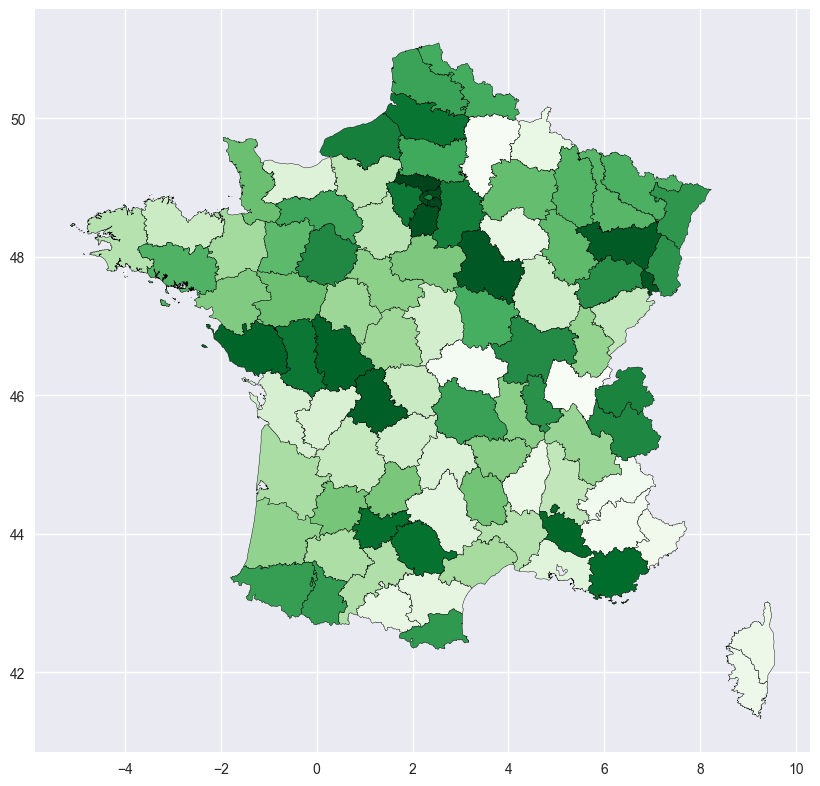

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_merged = map_df.merge(
    df_pred_126[df_pred_126["year"] == 2024], left_on="code", right_on="code_dep"
)
map_df.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    column="yield_pred",
    legend=True,
    cmap="Greens",
)

In [587]:
import os

output_path = "charts_pred/maps"
if not os.path.exists(output_path):
    os.makedirs(output_path)
# counter for the for loop
i = 0

# list of years (which are the column names at the moment)
list_of_years = df_pred_126["year"].unique()

In [ ]:
df_merged = pd.merge(map_df, df_pred_126, left_on="code", right_on="code_dep")[
    ["geometry", "department", "yield_pred", "year"]
]

vmin, vmax = df_merged["yield_pred"].min(), df_merged["yield_pred"].max()
for year in list_of_years:
    # filter the data for the specific year
    df_year = df_merged[df_merged["year"] == year]

    # plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    df_year.plot(
        column="yield_pred",
        ax=ax,
        legend=True,
        edgecolor="black",
        vmin=vmin,
        vmax=vmax,
        norm=plt.Normalize(vmin=vmin, vmax=vmax),
        cmap="Greens",
    )

    # Add big annotation of the year in bottom left corner
    ax.annotate(
        year,
        xy=(0, 0),
        xycoords="axes fraction",
        xytext=(20, 20),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=20,
    )

    plt.title(f"Barley yield in France in {year}")
    plt.savefig(f"{output_path}/barley_yield_in_france_in_{year}.png")
    plt.close()

    i += 1

In [620]:
# Concat the images to make a gif
import imageio

images = []
for year in list_of_years:
    images.append(imageio.imread(f"{output_path}/barley_yield_in_france_in_{year}.png"))

duration = 5  # seconds
nb_frames = len(list_of_years)
fps = int(nb_frames / duration)

imageio.mimsave(f"GIFYield_pred.gif", images, "GIF", fps=fps)